# PyTorch mutual information neural estimation tests

Trivial tests with multivariate Gaussian and uniform distribution

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchkld
import mutinfo

In [4]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda:1
Devices count: 2


In [5]:
from tqdm import tqdm, trange

In [6]:
from mutinfo.distributions.base import *
from mutinfo.distributions.mapped import mapped_multi_rv_frozen

In [7]:
from misc.modules import *
from misc.utils import *
from misc.plots import *

## Dataset

Experimental setup

In [8]:
mutual_information = 0.5

dataset_type = "UniformlyQuantized"
assert dataset_type in ["CorrelatedNormal", "CorrelatedStudent", "CorrelatedStudent_arcsinh", "CorrelatedUniform", "SmoothedUniform", "UniformlyQuantized"]
degrees_of_freedom = 2 # For Student's distribution

dimension = 4

In [11]:
randomize_interactions = False
shuffle_interactions = True

if dataset_type == "CorrelatedNormal":
    random_variable = CorrelatedNormal(mutual_information, dimension, dimension, randomize_interactions=randomize_interactions, shuffle_interactions=shuffle_interactions)

elif dataset_type in ["CorrelatedStudent", "CorrelatedStudent_arcsinh"]:
    random_variable = CorrelatedStudent(
        mutual_information, dimension, dimension, degrees_of_freedom, randomize_interactions=randomize_interactions, shuffle_interactions=shuffle_interactions
    )

    if dataset_type == "CorrelatedStudent_arcsinh":
        random_variable = mapped_multi_rv_frozen(random_variable, lambda x, y: (np.arcsinh(x), np.arcsinh(y)), lambda x, y: (np.sinh(x), np.sinh(y)))

    dataset_type += f"_dof_{degrees_of_freedom}"
    
elif dataset_type == "CorrelatedUniform":
    random_variable = CorrelatedUniform(mutual_information, dimension, dimension, randomize_interactions=randomize_interactions, shuffle_interactions=shuffle_interactions)

elif dataset_type == "SmoothedUniform":
    random_variable = SmoothedUniform(mutual_information, dimension, dimension, randomize_interactions=randomize_interactions)

elif dataset_type == "UniformlyQuantized":
    from scipy.stats import norm
    
    random_variable = UniformlyQuantized(mutual_information, dimension, dimension, norm(loc=0.0, scale=1.0))

In [12]:
n_samples = 10*1024
x, y = random_variable.rvs(n_samples)

## Estimating MI

Dataset and dataloader

In [13]:
batch_size = 2048
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float32),
    torch.tensor(y, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Model

In [14]:
inner_dim = 100

model = BasicDenseT(dimension, dimension, inner_dim=inner_dim).to(device)
total_parameters = sum(parameter.numel() for parameter in model.parameters())
print(f"Total parameters: {total_parameters}")

Total parameters: 11101


Loss

In [15]:
# Loss.
biased = False
ema_multiplier = 1.0e-2
marginalize = "product" # "permute", "product"

losses = {
    "DonskerVaradhan": torchkld.loss.DonskerVaradhanLoss(biased=biased, ema_multiplier=ema_multiplier),
    "NWJ": torchkld.loss.NWJLoss(),
    "Nishiyama": torchkld.loss.NishiyamaLoss(),
    "InfoNCE": torchkld.loss.InfoNCELoss(),
}

loss_name = "DonskerVaradhan"
loss = losses[loss_name]

Optimizer

In [16]:
learning_rate = 1.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [17]:
import matplotlib
from matplotlib import pyplot as plt

In [18]:
# Number of epochs used to average the estimate.
average_epochs = 200

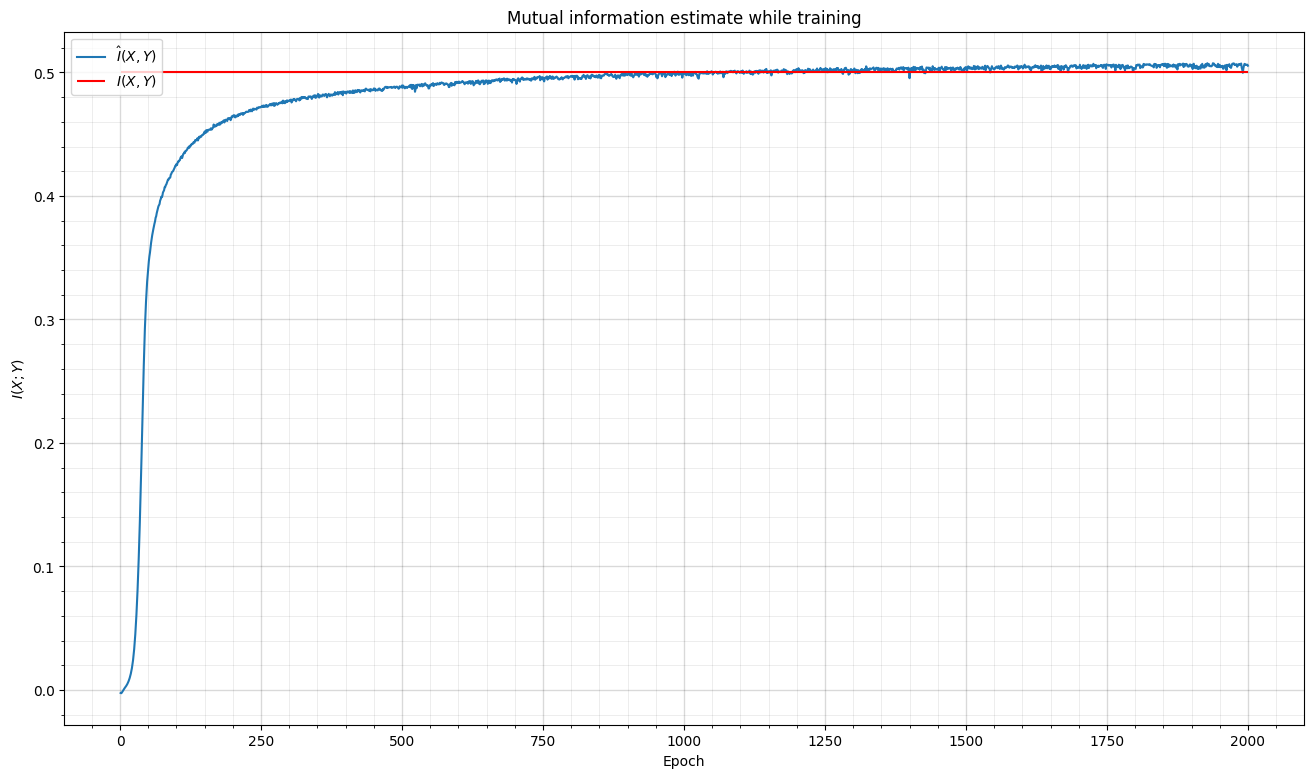

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [51:07<00:00,  1.53s/it]

Current estimate: 0.51
Running median: 0.51


In [19]:
from IPython.display import clear_output
from tqdm import trange
n_epochs = 2000

history = {"mutual_information": []}
for epoch in trange(1, n_epochs + 1, mininterval=1):    
    # Training.
    for index, batch in enumerate(dataloader):
        x, y = batch
        batch_size = x.shape[0]
        
        optimizer.zero_grad()
        
        T_joined   = model(x.to(device), y.to(device))
        T_marginal = model(x.to(device), y.to(device), marginalize=marginalize)
        _loss = loss(T_joined, T_marginal)
        _loss.backward()
        
        optimizer.step()
        
    history["mutual_information"].append(model.get_mutual_information(dataloader, loss, device, marginalize=marginalize))

    if epoch % 50 == 0:
        clear_output(wait=True)
        plot_estimated_MI_trainig(mutual_information, np.arange(1, epoch+1), history["mutual_information"])
        print(f"Current estimate: {history['mutual_information'][-1]:.2f}")
        print(f"Running median: {np.median(history['mutual_information'][-average_epochs:]):.2f}")

### Saving the results

In [20]:
parameters = {
    # Dataset.
    "dataset_type": dataset_type,
    "mutual_information": mutual_information,

    # Model.
    "inner_dim": inner_dim,

    # Loss.
    "loss_name": loss_name,
    "biased": biased,
    "ema_multiplier": ema_multiplier,

    # Training.
    "n_samples": n_samples,
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "learning_rate": learning_rate,

    # Saving the results.
    "average_epochs": average_epochs,
}

In [21]:
from datetime import datetime

experiment_name = f"{dataset_type}_{dimension}_{mutual_information:.1f}_{n_samples}__{datetime.now().strftime('%d-%b-%Y_%H:%M:%S')}"
print(experiment_name)

UniformlyQuantized_4_0.5_10240__04-Oct-2024_08:42:13


In [22]:
import os
from pathlib import Path

data_path = Path(os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../../data/synthetic")))
experiment_path = data_path / f"{dataset_type}" / loss_name / experiment_name

In [23]:
save_results(history, parameters, experiment_path, average_epochs=average_epochs)